In [1]:
import pandas as pd
import numpy as np

import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")
import os
import glob
import parsing

In [2]:
def get_merged_data(city) -> pd.DataFrame:
    """returns merged df of all the districts"""

    def get_raion_file(ind: int) -> pd.DataFrame:
        """take a raion files and returns df with raion name column"""
        file_data = pd.read_excel(list_of_files[ind])
        if not file_data.empty:
            file_data['raion_name'] = regions["raion_name"][ind]
        else:
            file_data = pd.DataFrame(data={'raion_name': [regions["raion_name"][ind]]})
        return file_data

    # read cian data
    path_to_cian_data = os.path.join(os.getcwd(), f"{city}_files", "")
    list_of_files = glob.glob(path_to_cian_data + "*.xlsx")
    # sort cian data by the time of download
    list_of_files.sort(key=os.path.getctime)

    offers_data = pd.DataFrame()
    for i in range(len(list_of_files)):
        raion_data = get_raion_file(i)
        offers_data = pd.concat([offers_data, raion_data], join='outer', ignore_index=True)

    return offers_data


In [92]:
def print_heat_map(data):
    fig, ax = plt.subplots(1, figsize=(40, 20))
    ax.axis('off')
    ax.set_title(F'Average appartment square meter price in {city.capitalize()} districts, rubles',
                 fontdict={'fontsize': '40', 'fontweight': '3'})

    # price borders
    vmin, vmax, vmean = data.average_price.min(), \
                        data.average_price.max(), data.average_price.mean()
    color = 'Blues'
    sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    cbar = fig.colorbar(sm)
    cbar.ax.tick_params(labelsize=20)

    data.plot('average_price', cmap=color, linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(40, 20))

    lower_bound, upper_bound = 5 / 8 * vmin + 3 / 8 * vmax, 5 / 8 * vmax + 3 / 8 * vmin
    # lower_bound, upper_bound = vmean, 3/4 * vmax + 1/4 * vmin
    for idx, row in data.iterrows():
        if lower_bound < row['average_price'] and row['average_price'] < upper_bound:
            plt.annotate(text=idx, xy=np.concatenate(row["center"].coords.xy),
                         horizontalalignment='left', fontsize='large', color='black', wrap=True)

    plt.show()
    

In [93]:
def heat_city(city):
    def get_average_price_data(offers):
        """returns df with average price in each district"""
        # add price and square columns
        offers["price"] = offers["Цена"].str.replace(' .+', '').astype(float)
        offers["square"] = offers["Площадь, м2"].str.replace('/.+', '').astype(float)

        # aggregate price and square data
        price_data = offers.groupby("raion_name").agg({"price": "sum", "square": "sum"})
        # calculate average price
        price_data[price_data.square < 10] = float(price_data.square.median())
        price_data["average_price"] = price_data.price / price_data.square

        # saort data by average price in descending order
        price_data.sort_values("average_price", ascending=False)

        return price_data

    global regions
    offers_data = get_merged_data(city)
    price_data = get_average_price_data(offers_data)

    # megred contains average price, geometry, and polygon center
    merged_df = regions.set_index('raion_name').join(price_data[["average_price"]])
    merged_df["center"] = merged_df.geometry.apply(lambda x: x.centroid)

    print_heat_map(merged_df)
    return price_data
    # end


In [84]:
def get_regions_data(city) -> pd.DataFrame:
    # read polygon data
    path_to_geo_data = os.path.join(os.getcwd(), 'forAnalysis', f'{city}.csv')
    return gpd.read_file(path_to_geo_data, GEOM_POSSIBLE_NAMES="geometry", KEEP_GEOM_COLUMNS="NO")


In [85]:
def city_input() -> str:
    """returns city name by entered index"""
    city_index = input("Enter the number of the city you want: "
                       "\n1 — Moscow;\n2 — SPB;\n3 — Ekaterinburg.\n").strip()
    if city_index not in ('1', '2', '3'):
        while True:
            city_index = input("Please, enter correct number of a city: "
                               "1 — Moscow; 2 — SPB; 3 — Ekaterinburg.\n").strip()
            if city_index in ('1', '2', '3'):
                break
    return ("moscow", "spb", 'ekaterinburg')[int(city_index) - 1]


Enter the number of the city you want: 
1 — Moscow;
2 — SPB;
3 — Ekaterinburg.
1
raion_name
Академический район       3.823834e+09
Алексеевский район        4.447743e+09
Алтуфьевский район        1.047480e+04
Бабушкинский район        3.014398e+09
Басманный район           9.006127e+09
                              ...     
район Южное Бутово        6.065813e+09
район Южное Медведково    2.747044e+09
район Южное Тушино        1.896236e+09
район Якиманка            2.266308e+10
район Ясенево             4.147613e+09
Name: price, Length: 121, dtype: float64

raion_name
Академический район       11610.10
Алексеевский район        14155.93
Алтуфьевский район        10474.80
Бабушкинский район        10477.96
Басманный район           21356.81
                            ...   
район Южное Бутово        22855.40
район Южное Медведково     9046.61
район Южное Тушино         9144.00
район Якиманка            34236.44
район Ясенево             12289.90
Name: square, Length: 121, dtype: float64

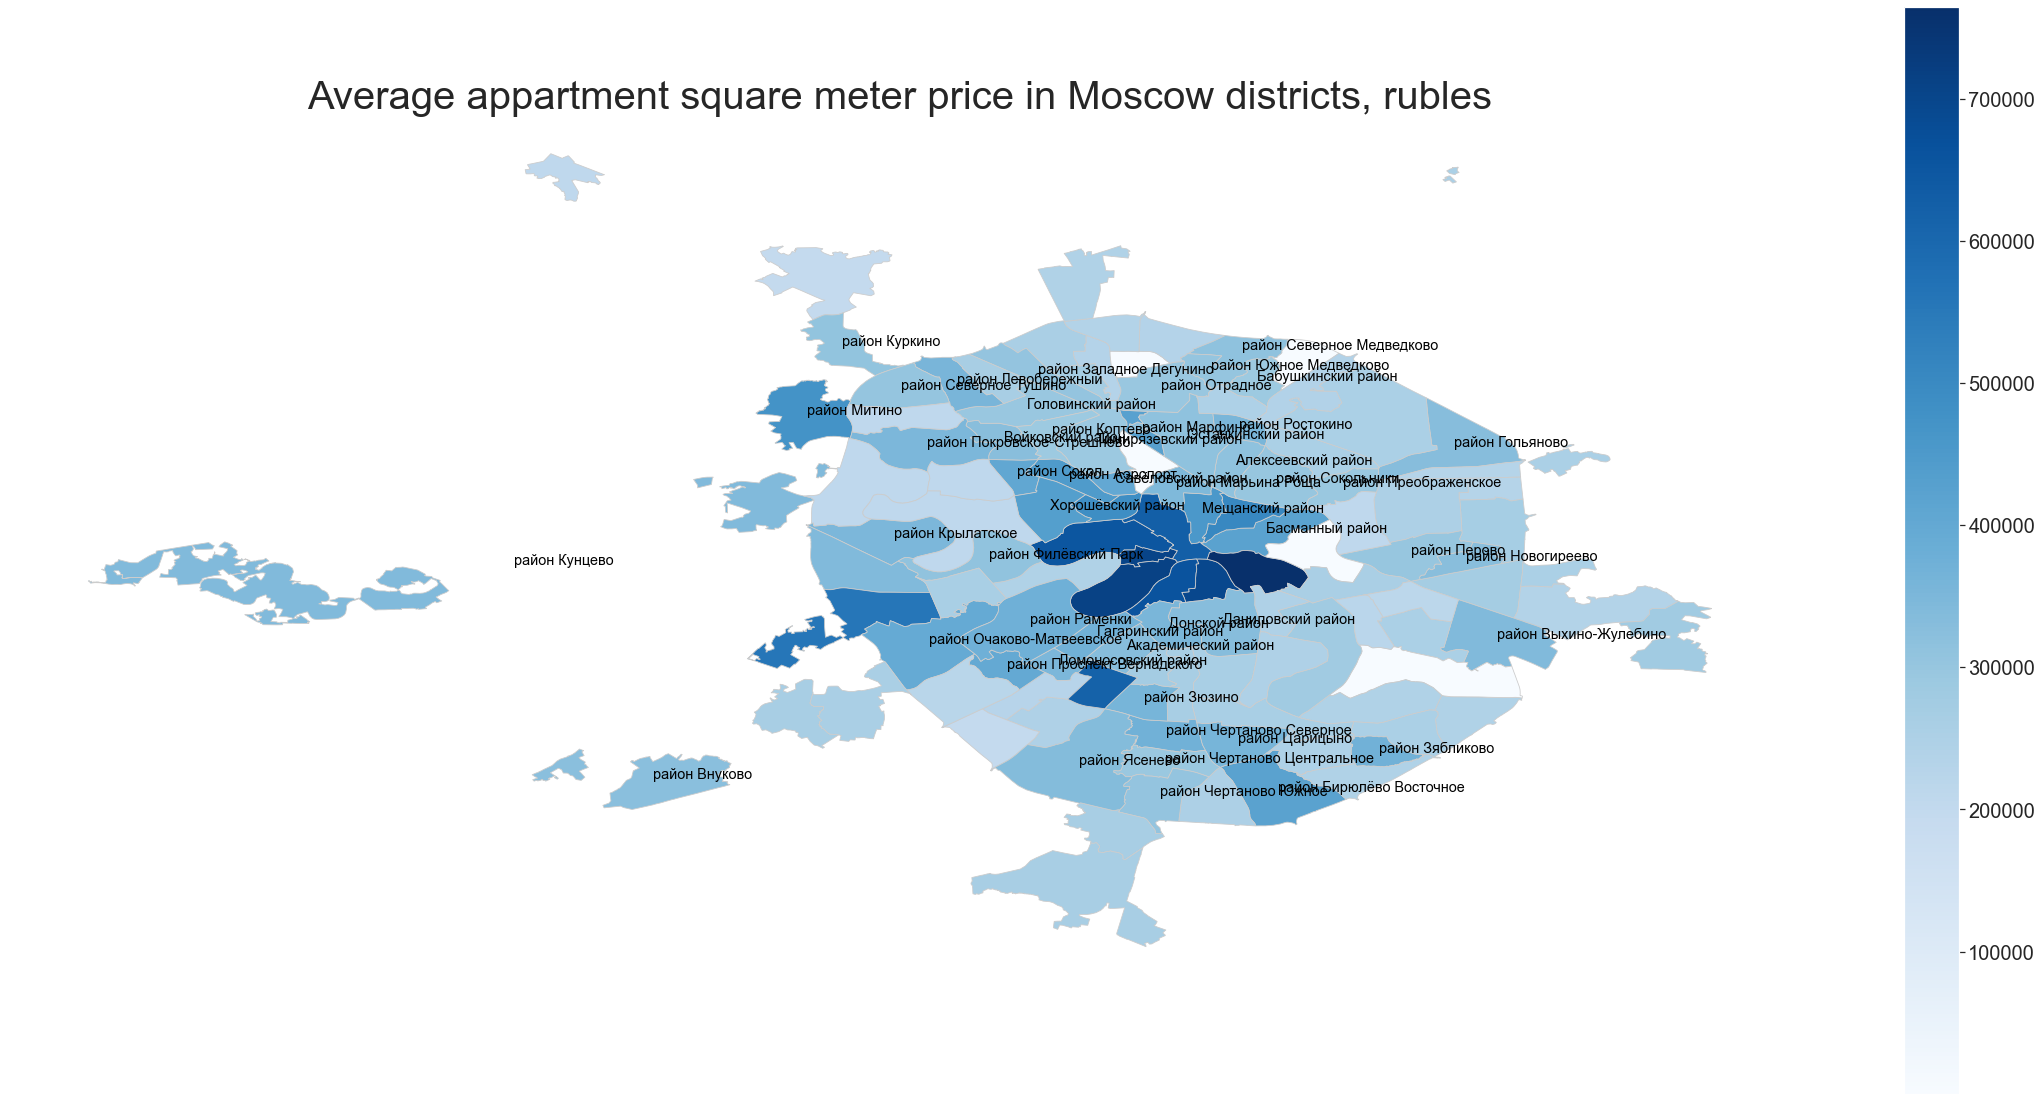

In [90]:
if __name__ == "__main__":
    city = city_input()

    # read polygon data
    regions = get_regions_data(city)

#     parsing.download_files(regions, city)

    msc = get_merged_data(city)
    price_data = heat_city(city)


In [91]:
regions

,okrug,raion_name,raion,geometry
0,центральный административный округ,район Арбат,арбат,"POLYGON ((37.57413 55.74545, 37.57445 55.74633..."
1,центральный административный округ,Басманный район,басманный,"POLYGON ((37.66592 55.75304, 37.66579 55.75303..."
2,центральный административный округ,район Замоскворечье,замоскворечье,"POLYGON ((37.62392 55.73011, 37.62394 55.73020..."
3,центральный административный округ,Красносельский район,красносельский,"POLYGON ((37.68484 55.78081, 37.68335 55.77970..."
4,центральный административный округ,Мещанский район,мещанский,"POLYGON ((37.62150 55.75916, 37.62144 55.75929..."
...,...,...,...,...
120,зеленоградский административный округ,район Матушкино,матушкино,"POLYGON ((37.21243 55.98703, 37.21217 55.98704..."
121,зеленоградский административный округ,район Савёлки,савёлки,"POLYGON ((37.23119 56.00462, 37.23540 56.00297..."
122,зеленоградский административный округ,район Старое Крюково,старое крюково,"POLYGON ((37.20838 55.96985, 37.18882 55.97413..."
123,зеленоградский административный округ,район Силино,силино,"POLYGON ((37.19047 56.01351, 37.18995 56.01341..."


In [68]:
price_data[price_data.square < 10] = price_data.square.median()

In [69]:
price_data

,price,square,average_price
raion_name,,,
Адмиралтейский район,1.004629e+04,10046.29,10046.290000
Василеостровский район,2.016988e+08,746.26,270279.554043
Выборгский район,6.696336e+09,19384.94,345440.107991
Калининский район,1.708061e+09,10008.79,170656.093094
Кировский район,9.695412e+08,7289.89,132998.051685
Колпинский район,1.182909e+10,24890.62,475242.815165
Красногвардейский район,1.594356e+09,8625.24,184847.719948
Красносельский район,1.000347e+10,24926.74,401314.957271
Кронштадтский район,2.205905e+09,11591.89,190297.258601
